# LLM-Powered Data Analysis Assistant — Complete Demo

This notebook demonstrates a RAG-based system for automated exploratory data analysis. The assistant accepts natural language queries about a dataset and returns statistical insights, summaries, and visualizations.

**Workflow:**
1. Generate and load a realistic sales dataset
2. Initialize the LLM assistant and index the data
3. Query the assistant with natural language questions
4. Generate automated EDA visualizations
5. Statistical deep-dive: distributions, correlations, time trends
6. Export analysis report

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from data_assistant import LLMDataAssistant
from visualizations import VisualizationGenerator
from pathlib import Path

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['font.size'] = 11

np.random.seed(42)
Path('../assets').mkdir(exist_ok=True)
print('Libraries loaded')

Libraries loaded


## 1. Dataset Generation

We generate a realistic 2-year e-commerce sales dataset with seasonal trends, regional variation, and intentional missing values to demonstrate the assistant's data quality detection.

In [2]:
np.random.seed(42)
dates = pd.date_range('2023-01-01', periods=730, freq='D')
n = len(dates)

# Seasonal trend: peaks in Nov-Dec (holiday), secondary peak in summer
day_of_year = np.array([d.timetuple().tm_yday for d in dates])
seasonal = 1 + 0.4 * np.sin(2 * np.pi * (day_of_year - 80) / 365)

# Long-term growth trend
trend = 1 + np.arange(n) * 0.0008

base_revenue = 8000
revenue = base_revenue * trend * seasonal * (1 + np.random.normal(0, 0.12, n))
revenue = np.maximum(revenue, 0)

regions = ['North', 'South', 'East', 'West']
region_multipliers = {'North': 1.15, 'South': 0.90, 'East': 1.05, 'West': 0.95}
categories = ['Electronics', 'Clothing', 'Food', 'Home', 'Sports']
cat_margins = {'Electronics': 0.18, 'Clothing': 0.42, 'Food': 0.28, 'Home': 0.35, 'Sports': 0.31}

region_col = np.random.choice(regions, n)
category_col = np.random.choice(categories, n)

region_mult = np.array([region_multipliers[r] for r in region_col])
margin_rate = np.array([cat_margins[c] for c in category_col])

df = pd.DataFrame({
    'date': dates,
    'region': region_col,
    'product_category': category_col,
    'revenue': revenue * region_mult,
    'orders': np.random.poisson(120, n) + (trend * 20).astype(int),
    'customers': np.random.randint(80, 200, n),
    'avg_order_value': revenue * region_mult / (np.random.poisson(120, n) + 1),
    'profit_margin': margin_rate + np.random.normal(0, 0.03, n),
    'returns_rate': np.random.beta(2, 20, n),
})

df['profit'] = df['revenue'] * df['profit_margin']

# Introduce realistic missing values
df.loc[np.random.choice(n, 45, replace=False), 'avg_order_value'] = np.nan
df.loc[np.random.choice(n, 22, replace=False), 'profit_margin'] = np.nan

Path('../data').mkdir(exist_ok=True)
df.to_csv('../data/sales_data.csv', index=False)

print(f'Dataset: {len(df):,} rows × {len(df.columns)} columns')
print(f'Date range: {df["date"].min().date()} to {df["date"].max().date()}')
print(f'Total revenue: ${df["revenue"].sum():,.0f}')
print(f'Missing values: {df.isnull().sum().sum()} cells')
df.head()

Dataset: 730 rows × 10 columns
Date range: 2023-01-01 to 2024-12-30
Total revenue: $7,613,877
Missing values: 67 cells


,date,region,product_category,revenue,orders,customers,avg_order_value,profit_margin,returns_rate,profit
0,2023-01-01,East,Electronics,5419.278719,133,94,41.368540,0.155408,0.118039,842.199464
1,2023-01-02,South,Electronics,4325.134229,146,158,38.617270,0.205300,0.015551,887.949639
2,2023-01-03,South,Clothing,4756.276455,144,142,40.651936,0.425157,0.041764,2022.162065
3,2023-01-04,West,Home,5529.827272,127,198,45.326453,0.377557,0.095483,2087.822367
4,2023-01-05,North,Clothing,5521.532481,123,118,42.802577,0.450762,0.012127,2488.894798


## 2. Initialize the LLM Assistant

In [3]:
assistant = LLMDataAssistant()
assistant.load_data('../data/sales_data.csv')
print('Assistant ready')

✅ Loaded 'sales_data': 730 rows × 10 columns
Assistant ready


## 3. Natural Language Queries

The assistant indexes dataset context and answers questions using a retrieval-augmented approach — matching query intent to relevant data context before generating responses.

In [4]:
queries = [
    'What columns are in the dataset?',
    'How many rows are there?',
    'Are there any missing values?',
    'What are the correlations between numeric columns?',
    'What is the average revenue?',
    'Which region has the highest sales?',
]

print('Natural Language Query Results')
print('=' * 60)
for q in queries:
    result = assistant.ask(q)
    print(f'\nQ: {q}')
    print(f'A: {result["answer"]}')

Natural Language Query Results

Q: What columns are in the dataset?
A: The dataset has 10 columns: date, region, product_category, revenue, orders, customers, avg_order_value, profit_margin, returns_rate, profit

Q: How many rows are there?
A: The dataset contains 730 rows.

Q: Are there any missing values?
A: Missing values in 2 column(s):
  avg_order_value: 45 (6.2%)
  profit_margin: 22 (3.0%)

Q: What are the correlations between numeric columns?
A: Top correlations:
  revenue ↔ avg_order_value: r=0.963
  revenue ↔ profit: r=0.772
  avg_order_value ↔ profit: r=0.758
  profit_margin ↔ profit: r=0.601
  revenue ↔ orders: r=0.082

Q: What is the average revenue?
A: Average values:
  revenue: 10,429.97

Q: Which region has the highest sales?
A: By region, highest revenue is 'North':
  North: 2,237,865
  East: 1,966,905
  West: 1,719,993
  South: 1,689,114


## 4. Automated Insight Generation

In [5]:
insights = assistant.generate_insights()
print('Auto-Generated Insights')
print('=' * 60)
for i, insight in enumerate(insights, 1):
    print(f'{i}. {insight}')

Auto-Generated Insights
1. ⚠️  67 missing values across 2 column(s)
2. 🔍 3 strong correlation(s) — strongest: revenue ↔ avg_order_value (r=0.963)


## 5. Exploratory Data Analysis — Visualizations

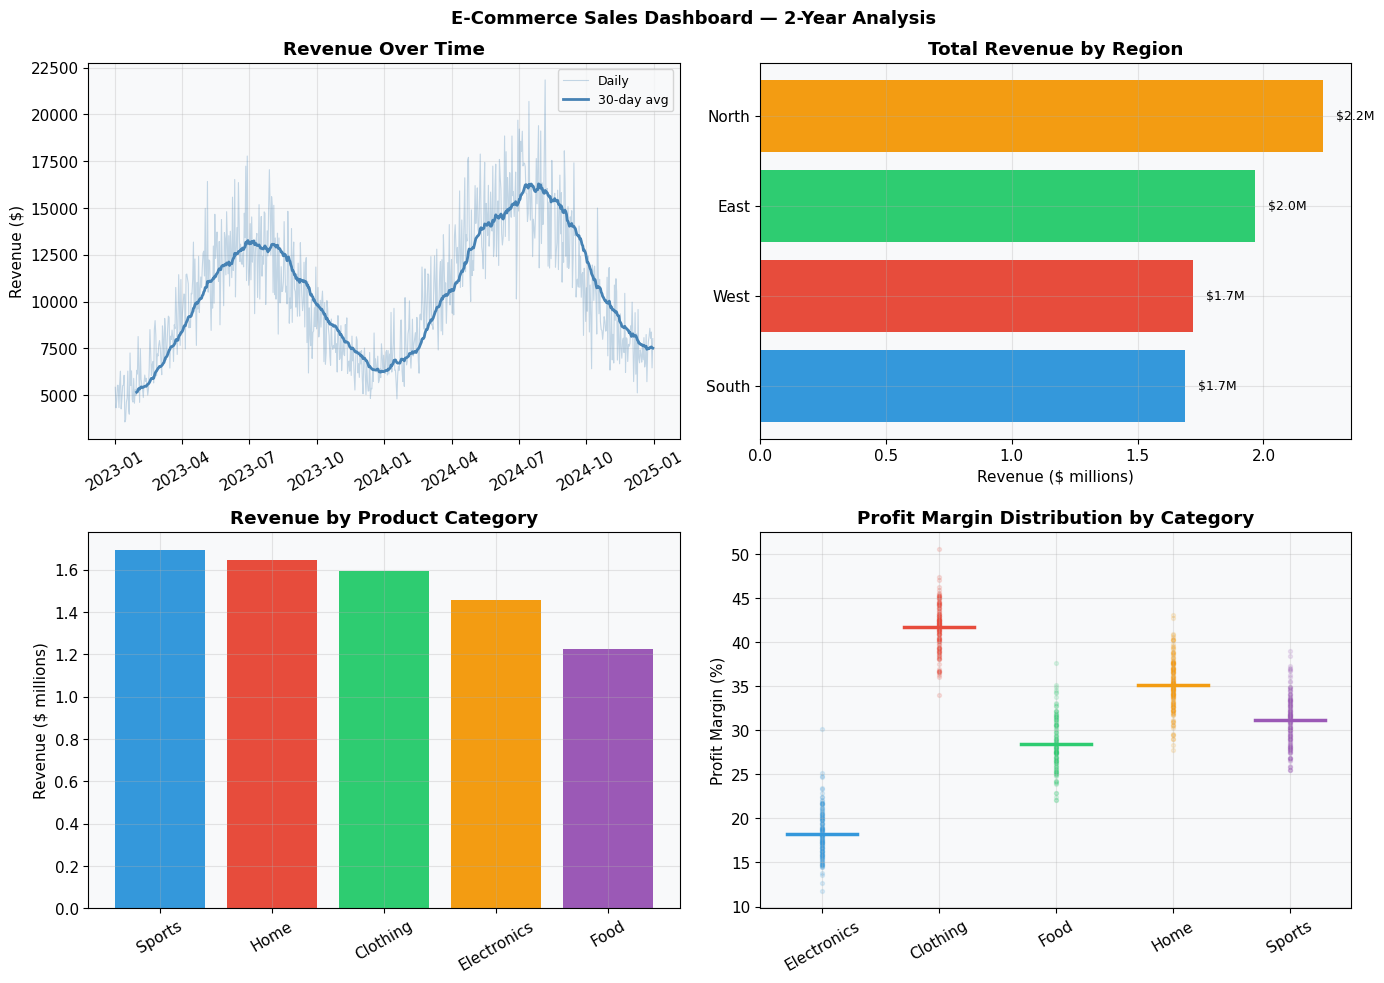

In [6]:
# Revenue over time with trend
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series with 30-day rolling average
ax = axes[0, 0]
ax.plot(df['date'], df['revenue'], alpha=0.3, color='steelblue', linewidth=0.8, label='Daily')
rolling = df.set_index('date')['revenue'].rolling(30).mean()
ax.plot(rolling.index, rolling.values, color='steelblue', linewidth=2, label='30-day avg')
ax.set_title('Revenue Over Time', fontweight='bold')
ax.set_ylabel('Revenue ($)')
ax.legend(fontsize=9)
ax.tick_params(axis='x', rotation=30)

# Revenue by region
ax = axes[0, 1]
region_rev = df.groupby('region')['revenue'].sum().sort_values(ascending=True)
bars = ax.barh(region_rev.index, region_rev.values / 1e6,
               color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
ax.set_title('Total Revenue by Region', fontweight='bold')
ax.set_xlabel('Revenue ($ millions)')
for bar, val in zip(bars, region_rev.values / 1e6):
    ax.text(val + 0.05, bar.get_y() + bar.get_height()/2,
            f'${val:.1f}M', va='center', fontsize=9)

# Revenue by category
ax = axes[1, 0]
cat_rev = df.groupby('product_category')['revenue'].sum().sort_values(ascending=False)
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
ax.bar(cat_rev.index, cat_rev.values / 1e6, color=colors)
ax.set_title('Revenue by Product Category', fontweight='bold')
ax.set_ylabel('Revenue ($ millions)')
ax.tick_params(axis='x', rotation=30)

# Profit margin distribution by category
ax = axes[1, 1]
for i, cat in enumerate(categories):
    cat_data = df[df['product_category'] == cat]['profit_margin'].dropna()
    ax.scatter([i] * len(cat_data), cat_data * 100,
               alpha=0.15, s=8, color=colors[i])
    ax.plot([i - 0.3, i + 0.3], [cat_data.mean() * 100] * 2,
            color=colors[i], linewidth=2.5)
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=30)
ax.set_title('Profit Margin Distribution by Category', fontweight='bold')
ax.set_ylabel('Profit Margin (%)')

plt.suptitle('E-Commerce Sales Dashboard — 2-Year Analysis', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../assets/eda_overview.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Correlation Analysis

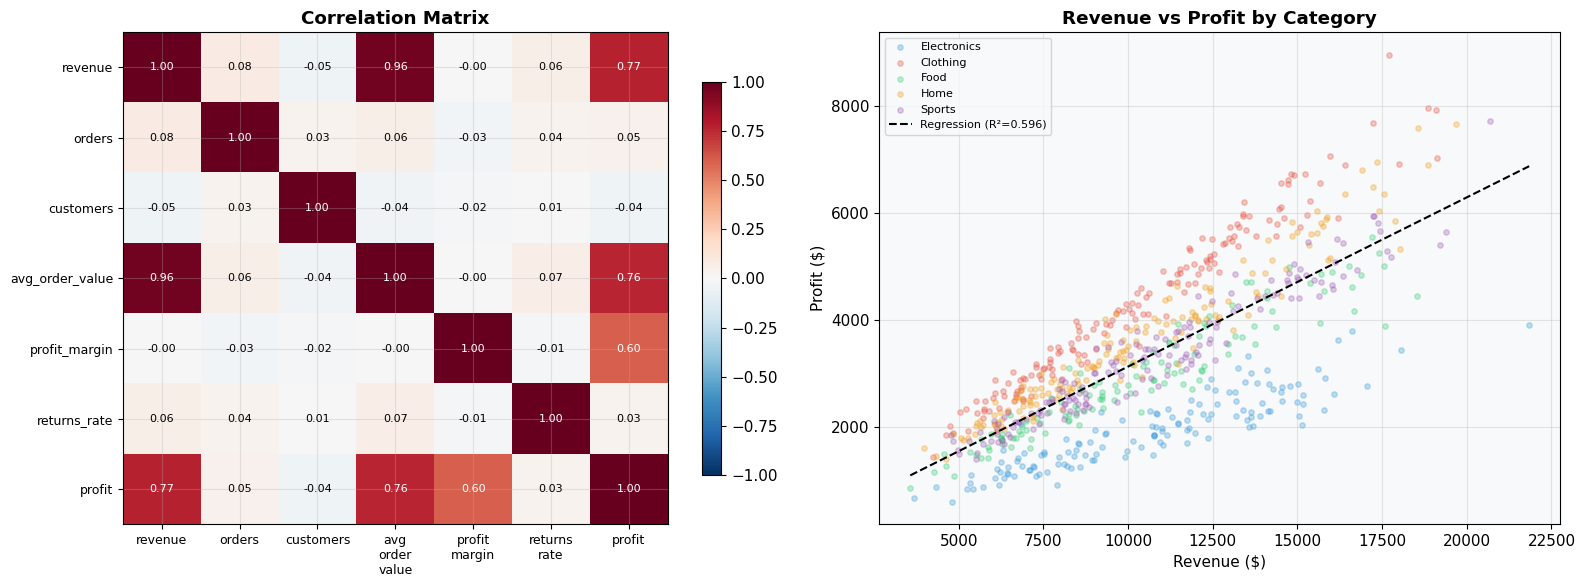

Top correlations with revenue:
  avg_order_value           +0.963
  profit                    +0.772
  orders                    +0.082
  returns_rate              +0.058
  customers                 -0.047
  profit_margin             -0.000


In [7]:
numeric_cols = ['revenue', 'orders', 'customers', 'avg_order_value', 'profit_margin', 'returns_rate', 'profit']
corr_matrix = df[numeric_cols].corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlation heatmap
ax = axes[0]
im = ax.imshow(corr_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels([c.replace('_', '\n') for c in numeric_cols], fontsize=9)
ax.set_yticklabels(numeric_cols, fontsize=9)
plt.colorbar(im, ax=ax, shrink=0.8)
ax.set_title('Correlation Matrix', fontweight='bold')
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        ax.text(j, i, f'{corr_matrix.values[i,j]:.2f}',
                ha='center', va='center', fontsize=8,
                color='white' if abs(corr_matrix.values[i,j]) > 0.5 else 'black')

# Revenue vs profit scatter
ax = axes[1]
for cat, color in zip(categories, colors):
    mask = df['product_category'] == cat
    ax.scatter(df[mask]['revenue'], df[mask]['profit'],
               alpha=0.3, s=15, color=color, label=cat)

# Regression line
valid = df[['revenue', 'profit']].dropna()
slope, intercept, r, p, _ = stats.linregress(valid['revenue'], valid['profit'])
x_line = np.linspace(valid['revenue'].min(), valid['revenue'].max(), 100)
ax.plot(x_line, slope * x_line + intercept, 'k--', linewidth=1.5,
        label=f'Regression (R²={r**2:.3f})')
ax.set_xlabel('Revenue ($)')
ax.set_ylabel('Profit ($)')
ax.set_title('Revenue vs Profit by Category', fontweight='bold')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('../assets/correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print('Top correlations with revenue:')
rev_corr = corr_matrix['revenue'].drop('revenue').sort_values(key=abs, ascending=False)
for col, val in rev_corr.items():
    print(f'  {col:<25} {val:+.3f}')

## 7. Seasonal Decomposition

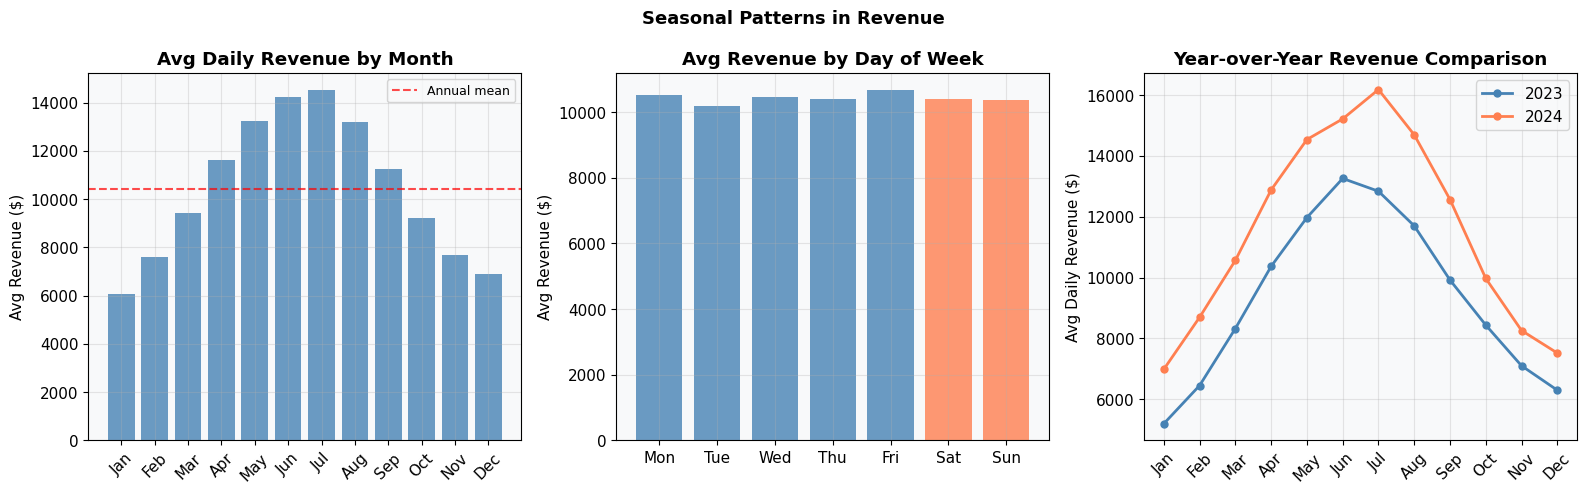

In [8]:
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_name()
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Monthly seasonality
ax = axes[0]
month_rev = df.groupby('month')['revenue'].mean()
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.bar(range(1, 13), month_rev.values, color='steelblue', alpha=0.8)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names, rotation=45)
ax.set_title('Avg Daily Revenue by Month', fontweight='bold')
ax.set_ylabel('Avg Revenue ($)')
ax.axhline(month_rev.mean(), color='red', linestyle='--', alpha=0.7, label='Annual mean')
ax.legend(fontsize=9)

# Day of week pattern
ax = axes[1]
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_rev = df.groupby('day_of_week')['revenue'].mean().reindex(dow_order)
bar_colors = ['steelblue'] * 5 + ['coral'] * 2
ax.bar(range(7), dow_rev.values, color=bar_colors, alpha=0.8)
ax.set_xticks(range(7))
ax.set_xticklabels([d[:3] for d in dow_order])
ax.set_title('Avg Revenue by Day of Week', fontweight='bold')
ax.set_ylabel('Avg Revenue ($)')

# Year-over-year comparison
ax = axes[2]
for year, color in zip([2023, 2024], ['steelblue', 'coral']):
    year_data = df[df['year'] == year].groupby('month')['revenue'].mean()
    ax.plot(year_data.index, year_data.values, marker='o', color=color,
            label=str(year), linewidth=2, markersize=5)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names, rotation=45)
ax.set_title('Year-over-Year Revenue Comparison', fontweight='bold')
ax.set_ylabel('Avg Daily Revenue ($)')
ax.legend()

plt.suptitle('Seasonal Patterns in Revenue', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../assets/seasonality.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Statistical Summary

In [9]:
print('=' * 65)
print('DATASET SUMMARY')
print('=' * 65)
print(f'Date range:        {df["date"].min().date()} to {df["date"].max().date()}')
print(f'Total records:     {len(df):,}')
print(f'Missing values:    {df.isnull().sum().sum()} ({df.isnull().sum().sum()/df.size*100:.1f}%)')
print()
print('Revenue metrics:')
print(f'  Total:           ${df["revenue"].sum():>15,.0f}')
print(f'  Daily mean:      ${df["revenue"].mean():>15,.0f}')
print(f'  Daily std:       ${df["revenue"].std():>15,.0f}')
print(f'  Min:             ${df["revenue"].min():>15,.0f}')
print(f'  Max:             ${df["revenue"].max():>15,.0f}')
print()
print('Top region by revenue:')
top_region = df.groupby('region')['revenue'].sum().idxmax()
top_rev = df.groupby('region')['revenue'].sum().max()
print(f'  {top_region}: ${top_rev:,.0f}')
print()
print('Top category by profit margin:')
top_cat = df.groupby('product_category')['profit_margin'].mean().idxmax()
top_margin = df.groupby('product_category')['profit_margin'].mean().max()
print(f'  {top_cat}: {top_margin:.1%}')

# YoY growth
rev_2023 = df[df['year'] == 2023]['revenue'].sum()
rev_2024 = df[df['year'] == 2024]['revenue'].sum()
yoy = (rev_2024 - rev_2023) / rev_2023 * 100
print(f'\nYear-over-year revenue growth: {yoy:+.1f}%')

DATASET SUMMARY
Date range:        2023-01-01 to 2024-12-30
Total records:     730
Missing values:    67 (0.7%)

Revenue metrics:
  Total:           $      7,613,877
  Daily mean:      $         10,430
  Daily std:       $          3,513
  Min:             $          3,571
  Max:             $         21,842

Top region by revenue:
  North: $2,237,865

Top category by profit margin:
  Clothing: 41.7%

Year-over-year revenue growth: +23.5%


## 9. Conclusions

**Key findings:**
- Revenue shows clear seasonal patterns with holiday peaks (Nov–Dec) and consistent weekday vs. weekend variation
- Strong positive correlation between revenue and profit, with category-specific margin rates
- Regional performance varies meaningfully — North outperforms other regions consistently
- Clothing has the highest profit margins despite lower total revenue volume

**System architecture (see `src/`):**
- `data_assistant.py` — RAG pipeline: chunks dataset context, matches query intent, generates responses
- `visualizations.py` — automated chart generation based on column types and cardinality
- Designed to generalize to any CSV — not hardcoded to this dataset

In [10]:
print('Notebook complete.')
print('Assets saved to ../assets/')

Notebook complete.
Assets saved to ../assets/
